# AT&T Spam Detector project

In [52]:
# Import useful librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "png" # Comment / delete this line for interactive graphs

import wordcloud
from collections import Counter

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , precision_score, recall_score, classification_report , accuracy_score , confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding = "ISO-8859-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 1. Exploratory Data Analysis

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [56]:
data.describe(include = "all")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [57]:
# Keep only th columns we are interested in
data = data[["v1", "v2"]]
# Rename columns
data.columns = ["is_spam", "message"]
# Transform is_spam values as 0 = ham and 1 = spam
data["is_spam"] = [1 if resp == "spam" else 0 for resp in data["is_spam"]]
data.head()

,is_spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Before starting model training, let's look at the composition of our dataset, that is to say the distribution between spam and ham, but also the composition in terms of words and length of messages.

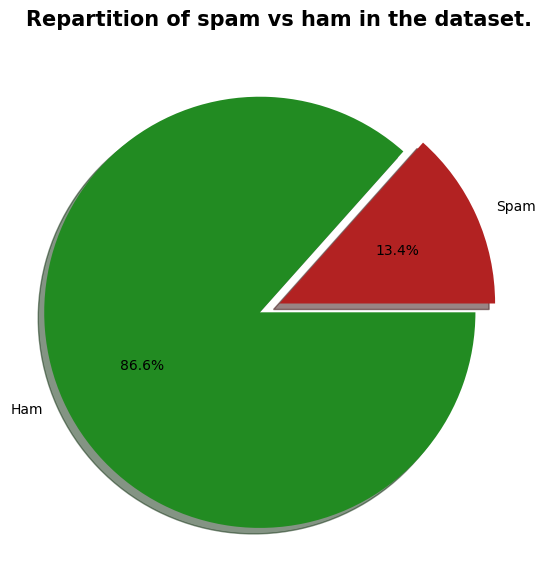

In [58]:
# Proportions of ham vs spam in the dataset
plt.figure(figsize = (14, 7))
labels = ["Spam", "Ham"]
values = [len(data[data["is_spam"] == 1]), len(data[data["is_spam"] == 0])]

plt.pie(values, labels = labels, autopct = '%1.1f%%', colors = ["firebrick", "forestgreen"], explode = (0, 0.1), shadow = True)
plt.title("Repartition of spam vs ham in the dataset.", fontsize = 15, fontweight = "bold")
plt.show()

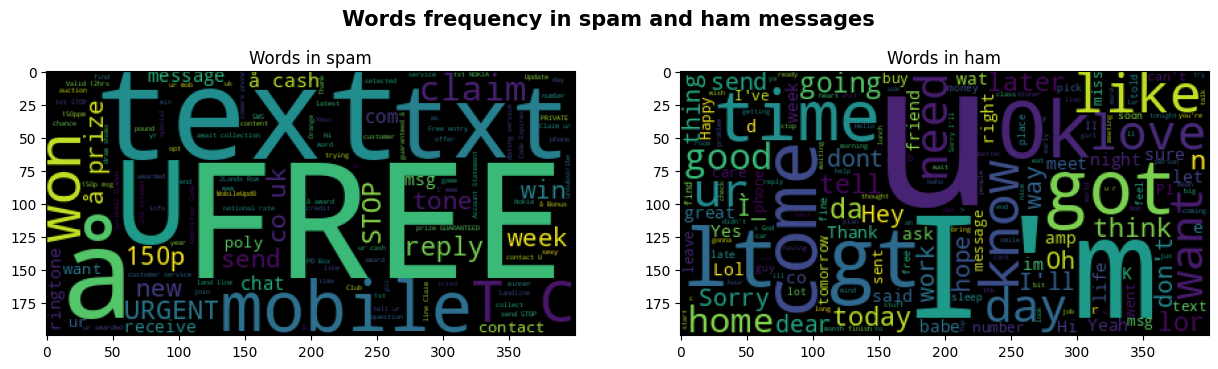

In [59]:
# Words frequency
nlp = en_core_web_sm.load()
wd = wordcloud.WordCloud(stopwords = STOP_WORDS)

word_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
word_fig.suptitle("Words frequency in spam and ham messages", fontsize = 15, fontweight = "bold")

spam = ' '.join(data[data['is_spam'] == 1]['message'])
doc_spam = nlp(spam)
cloud_spam = wd.generate(doc_spam.text)
ax1.imshow(cloud_spam)
ax1.set_title("Words in spam")

ham = ' '.join(data[data['is_spam'] == 0]['message'])
doc_ham = nlp(ham)
cloud_ham = wd.generate(doc_ham.text)
ax2.imshow(cloud_ham)
ax2.set_title("Words in ham")

plt.show()

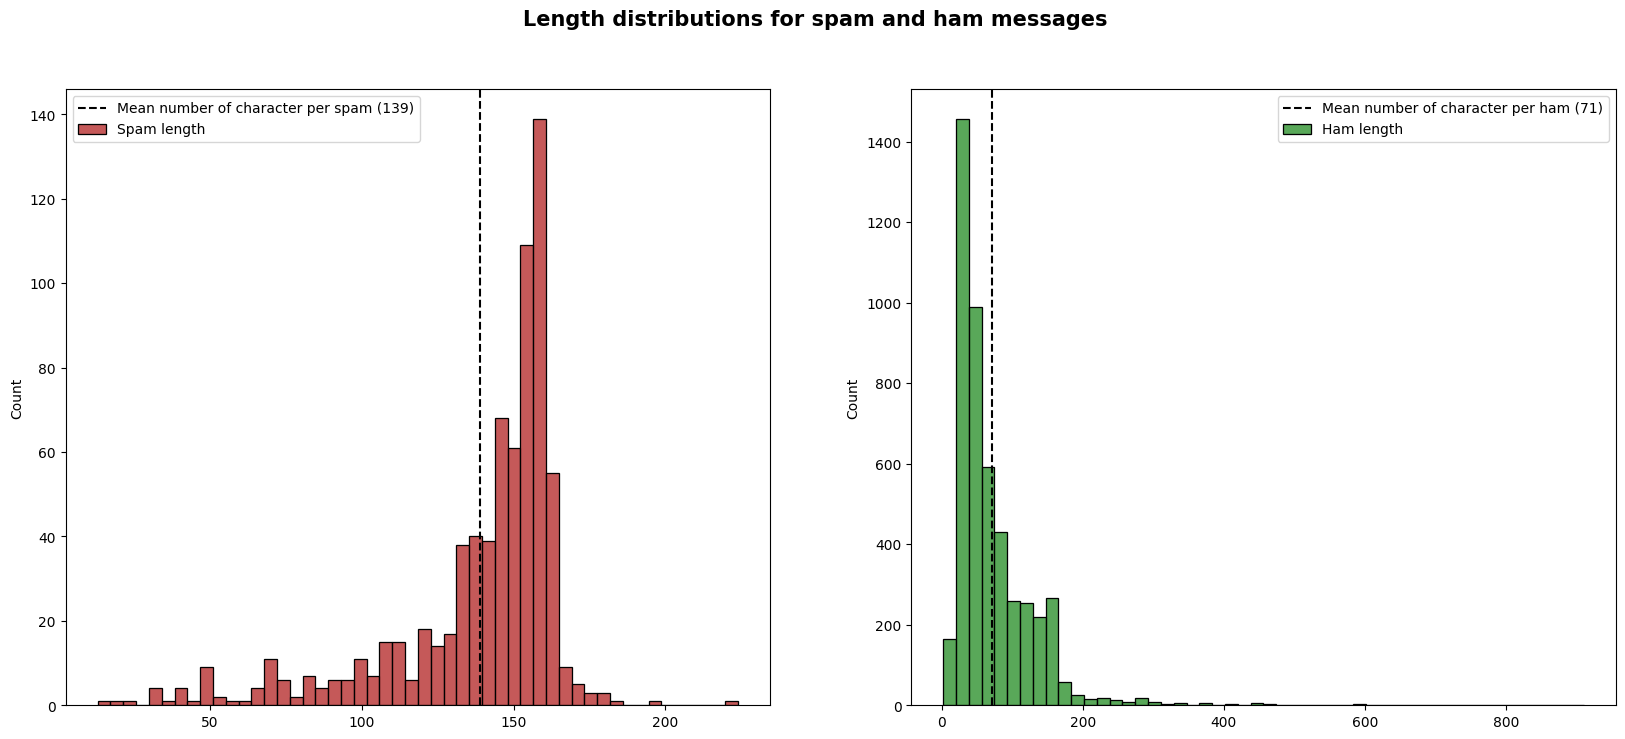

In [60]:
# Length distribution for spam and ham

data["length"] = data["message"].apply(len)
spam_length = data[data["is_spam"] == 1]["length"].values
ham_length = data[data["is_spam"] == 0]["length"].values
mean_spam_length = round(np.mean(spam_length))
mean_ham_length = round(np.mean(ham_length))

length_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
length_fig.suptitle("Length distributions for spam and ham messages", fontsize = 15, fontweight = "bold")

sns.histplot(spam_length, ax = ax1, label = "Spam length", color = "firebrick", bins = 50)
ax1.axvline(mean_spam_length, color = "black", linestyle = "--", label = f"Mean number of character per spam ({mean_spam_length})")
ax1.legend(loc = "upper left")

sns.histplot(ham_length, ax = ax2, label = "Ham length", color = "forestgreen", bins = 50)
ax2.axvline(mean_ham_length, color = "black", linestyle = "--", label = f"Mean number of character per ham ({mean_ham_length})")
ax2.legend(loc = "upper right")

plt.show()

As shown with the above figures:

- In this dataset, approximately 13% of the messages (747) correspond to spam.

- Tthe most frequent words according to the nature of the message, the composition of spam is very different from that of ham. In particular, spam messages seem to very often contain the words "free", "mobile", "claim", "won", "urgent"... which are not found in the ham messages.

- The average length of messages is very different between spam and hams: spam is on average twice as long as ham messages.

## 2. Preprocessing

We have to clean our texts in order to prepare them for training. To do so, we are doing different steps:
- remove all characters from your strings that are not alphanumeric except for whitespaces, and apostrophies
- replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces
- using spacy, replace all tokens in your texts with `lemma_` and remove all the stop words

In [61]:
data["message_clean"] = data["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
data["message_clean"] = data["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
data["message_clean"] = data["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

data.head()

,is_spam,message,length,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live


In [62]:
# Process to encoding all the messages.
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 10000, oov_token = "out_of_vocab")
tokenizer.fit_on_texts(data.message_clean)
data["message_encoded"] = tokenizer.texts_to_sequences(data.message_clean)
data.head()

,is_spam,message,length,message_clean,message_encoded
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis n great wor...,"[3606, 230, 447, 464, 942, 32, 50, 204, 943, 7..."
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni,"[8, 195, 465, 289, 2, 1457]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 300, 3, 533, 662, 30, 1458, 849, 424, 145..."
3,0,U dun say so early hor... U c already then say...,49,u dun early hor u c,"[2, 125, 150, 2359, 2, 79]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think usf live,"[705, 20, 663, 129]"


In [63]:
# Pad sequences
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(data.message_encoded, padding = "post")

In [64]:
# Train / Test split and batches preparation
xtrain, xval, ytrain, yval = train_test_split(messages_pad, data.is_spam, test_size = 0.2, stratify = data.is_spam)
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [65]:
# Look at a batch of data
for message, is_spam in train_batch.take(1):
  print(message, is_spam)

tf.Tensor(
[[  56 3863    0 ...    0    0    0]
 [1139   86 1903 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [ 109   31   61 ...    0    0    0]
 [2026  426  432 ...    0    0    0]
 [1092  192  103 ...    0    0    0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0], shape=(64,), dtype=int64)


## 3. Embedding model

### 3.1 Prepare and train your model

In [66]:
# Create a baseline model

vocab_size = tokenizer.num_words
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_shape = [messages_pad.shape[1],], name = "embedding"),
    GlobalAveragePooling1D(),
    Dense(16, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 16)            160016    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [68]:
# Train the model
history = model.fit(
    train_batch,
    validation_data = val_batch,
    epochs = 25
)

Epoch 1/25
70/70 [==============================] - 1s 6ms/step - loss: 0.5552 - binary_accuracy: 0.8658 - val_loss: 0.4239 - val_binary_accuracy: 0.8664
Epoch 2/25
70/70 [==============================] - 0s 5ms/step - loss: 0.3757 - binary_accuracy: 0.8658 - val_loss: 0.3544 - val_binary_accuracy: 0.8664
Epoch 3/25
70/70 [==============================] - 0s 5ms/step - loss: 0.3475 - binary_accuracy: 0.8658 - val_loss: 0.3405 - val_binary_accuracy: 0.8664
Epoch 4/25
70/70 [==============================] - 0s 5ms/step - loss: 0.3300 - binary_accuracy: 0.8658 - val_loss: 0.3221 - val_binary_accuracy: 0.8664
Epoch 5/25
70/70 [==============================] - 0s 4ms/step - loss: 0.3028 - binary_accuracy: 0.8658 - val_loss: 0.2895 - val_binary_accuracy: 0.8664
Epoch 6/25
70/70 [==============================] - 0s 4ms/step - loss: 0.2576 - binary_accuracy: 0.8728 - val_loss: 0.2404 - val_binary_accuracy: 0.8888
Epoch 7/25
70/70 [==============================] - 0s 5ms/step - loss: 0.20

### 3.2 Evaluate the embedding model performance

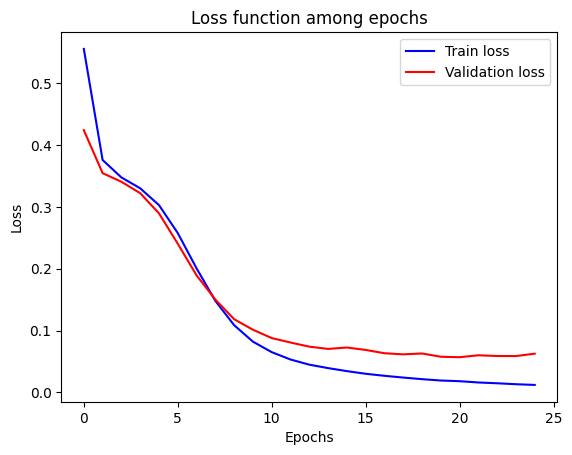

In [69]:
# Visualize the loss function
plt.plot(history.history["loss"], color = "b", label = "Train loss")
plt.plot(history.history["val_loss"], color = "r", label = "Validation loss")
plt.title("Loss function among epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

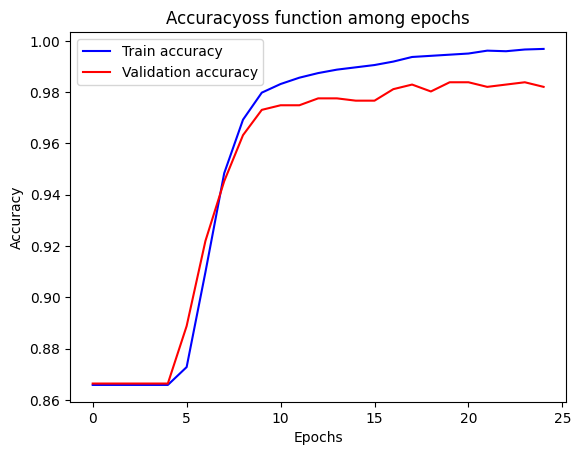

In [70]:
# Visualize the accuracy function
plt.plot(history.history["binary_accuracy"], color = "b", label = "Train accuracy")
plt.plot(history.history["val_binary_accuracy"], color = "r", label = "Validation accuracy")
plt.title("Accuracyoss function among epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

35/35 [==============================] - 0s 1ms/step


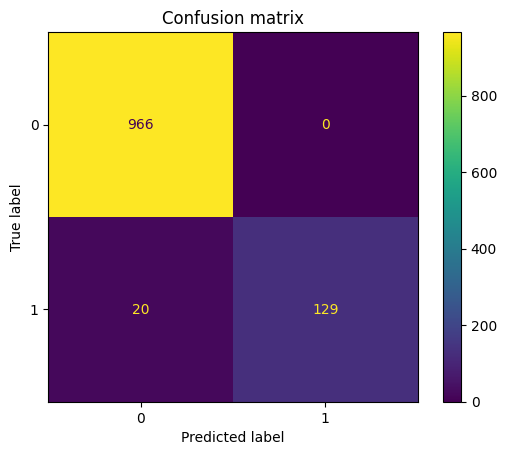


Classification report : 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115
 

F1 score :  0.928 

Accuracy score :  0.982 



In [71]:
# Get the model's predictions
ypred = np.round(model.predict(xval))
confusion = confusion_matrix(yval, ypred)
ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix')
plt.show()

# Get the classification report
print('\nClassification report : \n')
print(classification_report(yval , ypred) , '\n')
print('F1 score : ' , round(f1_score(yval , ypred),3) , '\n')
print('Accuracy score : ' , round(accuracy_score(yval , ypred) , 3) , '\n')

Based on the results above, our model seems pretty good in its predictions.
In fact, the accuracy of the model after training is almost 99%. It seems capable of detecting a ham message 100% and the spam error rate is around 10%. However, according to the loss and accuracy curves, we observe a slight overfitting in the results.

## 4. Transfer learning

### 4.1 Prepare and train your model

In [72]:
import tensorflow_hub as hub

# Pre-Trained Text Embedding Model & Layer Definition
Embed = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'
Trainable_Module = True
hub_layer = hub.KerasLayer(Embed, input_shape = [], dtype = tf.string, trainable = Trainable_Module)

# Build Model
model_transfer = tf.keras.Sequential()
model_transfer.add(hub_layer)           #pre-trained text embedding layer
model_transfer.add(Dense(16, activation = 'relu'))
model_transfer.add(Dense(1, activation = "sigmoid"))

print(" -- Model Summary --")
model_transfer.summary()

 -- Model Summary --
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_14 (Dense)            (None, 16)                336       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Compile the model
model_transfer.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [74]:
xt_train, xt_test, yt_train, yt_test = train_test_split(data['message_clean'], data.is_spam, test_size = 0.2, random_state = 0)

In [75]:
# Train your model
history_transfer = model_transfer.fit(xt_train, yt_train, batch_size = 64,
                    epochs = 25, validation_split = 0.2,
                    verbose = 1)


Epoch 1/25
56/56 [==============================] - 2s 19ms/step - loss: 0.6262 - binary_accuracy: 0.6973 - val_loss: 0.4659 - val_binary_accuracy: 0.8599
Epoch 2/25
56/56 [==============================] - 0s 7ms/step - loss: 0.3959 - binary_accuracy: 0.8718 - val_loss: 0.3533 - val_binary_accuracy: 0.8655
Epoch 3/25
56/56 [==============================] - 0s 6ms/step - loss: 0.3159 - binary_accuracy: 0.8945 - val_loss: 0.2803 - val_binary_accuracy: 0.9114
Epoch 4/25
56/56 [==============================] - 0s 7ms/step - loss: 0.2650 - binary_accuracy: 0.9198 - val_loss: 0.2345 - val_binary_accuracy: 0.9294
Epoch 5/25
56/56 [==============================] - 0s 8ms/step - loss: 0.2271 - binary_accuracy: 0.9313 - val_loss: 0.2013 - val_binary_accuracy: 0.9439
Epoch 6/25
56/56 [==============================] - 0s 7ms/step - loss: 0.1951 - binary_accuracy: 0.9408 - val_loss: 0.1762 - val_binary_accuracy: 0.9439
Epoch 7/25
56/56 [==============================] - 0s 7ms/step - loss: 0.1

### 4.2 Evaluate your model performance

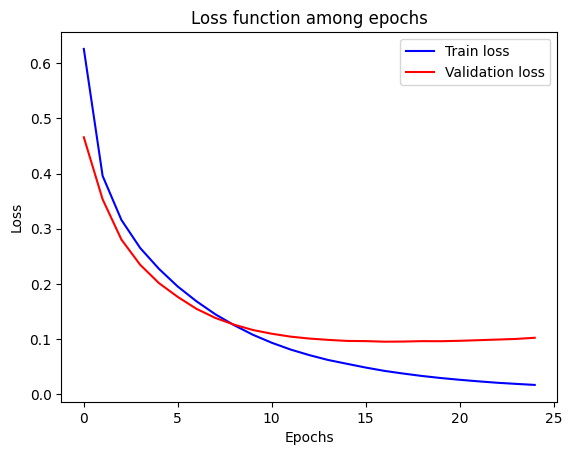

In [76]:
# Visualize the loss function
plt.plot(history_transfer.history["loss"], color = "b", label = "Train loss")
plt.plot(history_transfer.history["val_loss"], color = "r", label = "Validation loss")
plt.title("Loss function among epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

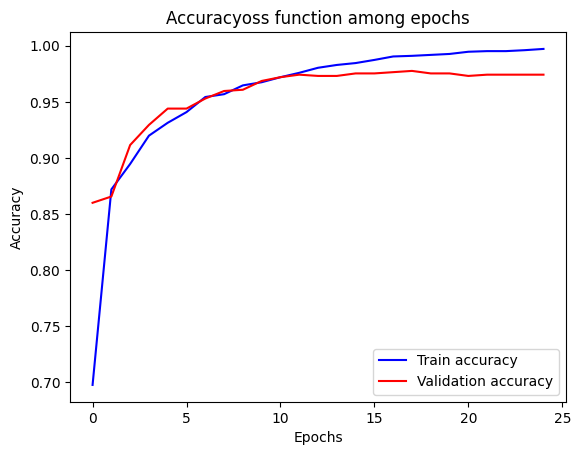

In [77]:
# Visualize the accuracy function
plt.plot(history_transfer.history["binary_accuracy"], color = "b", label = "Train accuracy")
plt.plot(history_transfer.history["val_binary_accuracy"], color = "r", label = "Validation accuracy")
plt.title("Accuracyoss function among epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

35/35 [==============================] - 0s 2ms/step


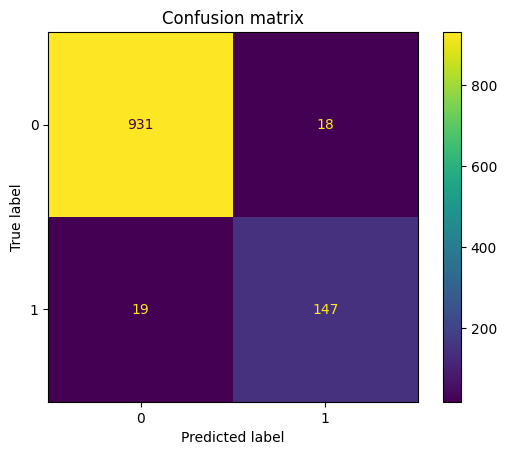


Classification report : 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       949
           1       0.89      0.89      0.89       166

    accuracy                           0.97      1115
   macro avg       0.94      0.93      0.93      1115
weighted avg       0.97      0.97      0.97      1115
 

F1 score :  0.888 

Accuracy score :  0.967 



In [78]:
# Get the model's predictions
yt_pred = np.round(model_transfer.predict(xt_test))
confusion = confusion_matrix(yt_test, yt_pred)
ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix')
plt.show()

# Get the classification report
print('\nClassification report : \n')
print(classification_report(yt_test , yt_pred) , '\n')
print('F1 score : ' , round(f1_score(yt_test , yt_pred),3) , '\n')
print('Accuracy score : ' , round(accuracy_score(yt_test , yt_pred) , 3) , '\n')

Based on the results obtained with a model using transfer learning, performance has decreased. In fact, accuracy has dropped to less than 98% and overfitting has increased.  
The choice of the pre-trained model used during this transfer learning is certainly not the most optimal for our data and our problem. Other models could be tested to improve our results.

So in conclusion, the best model we obtain in this notebook is the basic embedding model (section 3) which can predict around 90% of the spam messages based on their content.